In [3]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import diverging_palette

import sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.linear_model import (
    LogisticRegression,
    Lasso
)

from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier
)

from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    RepeatedStratifiedKFold,
    GridSearchCV,
    KFold
)

from sklearn.metrics import (
    accuracy_score, 
    precision_score, average_precision_score,
    precision_recall_curve,
    confusion_matrix, plot_confusion_matrix,
    roc_curve, roc_auc_score,
    classification_report
)

import lightgbm as lgb
from lightgbm import LGBMClassifier, plot_importance

from yellowbrick.classifier import (
    ConfusionMatrix,
    ROCAUC
)

import warnings
from warnings import simplefilter
warnings.filterwarnings("ignore")
simplefilter("ignore", category=ConvergenceWarning)

# Load Dataset into DataFrame

In [4]:
url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/Airline-Passenger-Satisfaction-Prediction/main/Data/df5.csv'
data = pd.read_csv(url)
data

,Age,Class,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,...,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,satisfaction,Gender_Male,Customer_Type_Loyal Customer,Type_of_Travel_Business travel
0,26.0,0.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,...,3.0,4.0,4.0,4.0,5.0,0.0,1.0,0.0,1.0,1.0
1,61.0,0.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,...,4.0,4.0,3.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0
2,47.0,2.0,1276.0,2.0,4.0,2.0,3.0,2.0,2.0,2.0,...,3.0,4.0,3.0,5.0,2.0,9.0,0.0,1.0,1.0,0.0
3,52.0,0.0,2035.0,4.0,3.0,4.0,4.0,5.0,5.0,5.0,...,5.0,5.0,4.0,5.0,4.0,4.0,1.0,0.0,1.0,1.0
4,20.0,2.0,1061.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,...,3.0,4.0,4.0,3.0,2.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43954,26.0,0.0,712.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,...,4.0,4.0,3.0,4.0,5.0,17.0,1.0,1.0,1.0,1.0
43955,57.0,2.0,867.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0,...,4.0,3.0,1.0,3.0,4.0,0.0,0.0,1.0,1.0,1.0
43956,60.0,0.0,1599.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,...,4.0,4.0,4.0,4.0,4.0,9.0,1.0,0.0,1.0,1.0
43957,50.0,2.0,1620.0,3.0,1.0,3.0,4.0,2.0,3.0,2.0,...,3.0,4.0,2.0,4.0,2.0,0.0,0.0,1.0,1.0,0.0


# Data Preparation

## Standardization of numeric variables

In [5]:
numeric_cols = ['Age', 'Flight_Distance','Departure_Delay_in_Minutes']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

## Handling Missing values

The satisfaction level of each feature should range from 1 to 5. 

If the rating is 0, that means the customer did not rate for this feature.


In [6]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [7]:
list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more t

In [8]:
incomplete = ['Inflight_wifi_service','Departure/Arrival_time_convenient',
              'Ease_of_Online_booking','Online_boarding','Leg_room_service']
(data[incomplete] == 0).sum()

Inflight_wifi_service                 67
Departure/Arrival_time_convenient    134
Ease_of_Online_booking                58
Online_boarding                       16
Leg_room_service                       1
dtype: int64

In [9]:
(data[incomplete] == 0).sum().sum()/data.shape[0]

0.00627857776564526

We should consider rating=0 as missing values as the customer did not provide any rating feedback.

Considering the total number of rows that contains missing ratings only takes up 0.6% of the dataset, we simply drop these observations.

In [10]:
data = data.loc[(data[incomplete] != 0).all(axis=1)]

list_column_values(data, data.shape[1],'True')

**Results:**

Age                       ==> more than 22 values
Class                     ==> [0.0, 1.0, 2.0]
Flight_Distance           ==> more than 22 values
Inflight_wifi_service     ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure/Arrival_time_convenient ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Ease_of_Online_booking    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Gate_location             ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Food_and_drink            ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Online_boarding           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Seat_comfort              ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_entertainment    ==> [1.0, 2.0, 3.0, 4.0, 5.0]
On-board_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Leg_room_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Baggage_handling          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Checkin_service           ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Inflight_service          ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Cleanliness               ==> [1.0, 2.0, 3.0, 4.0, 5.0]
Departure_Delay_in_Minutes ==> more than 22 values
satisfactio

In [9]:
data.shape

(43756, 22)

# Splitting the Dataset

Identify features and target

In [11]:
X = data.drop(columns=['satisfaction'])
y = data['satisfaction']

## Train Test Split

In [12]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

N_train, _ = X_train.shape 
N_val_test,  _ = X_val_test.shape 

N_train, N_val_test

(35004, 8752)

## Test Validation Split

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 777)

N_val, _ = X_val.shape 
N_test,  _ = X_test.shape 

N_val, N_test

(4376, 4376)

In [14]:
data.columns

Index(['Age', 'Class', 'Flight_Distance', 'Inflight_wifi_service',
       'Departure/Arrival_time_convenient', 'Ease_of_Online_booking',
       'Gate_location', 'Food_and_drink', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment', 'On-board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Inflight_service',
       'Cleanliness', 'Departure_Delay_in_Minutes', 'satisfaction',
       'Gender_Male', 'Customer_Type_Loyal Customer',
       'Type_of_Travel_Business travel'],
      dtype='object')

# Functions for Evaluation Metrics

### ROC Curve

In [15]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### PR Curve

In [16]:
def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

### Classification Score

It gets the model and evaluates it for training and validation.

In [17]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))

    elif train == False:
        print("Validation Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("roc auc score: {}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_val, clf.predict(X_val))))
        plot_confusion_matrix(clf,  X_val, clf.predict(X_val))
        print("End of validation Result\n")

### Model Results Comparison

In [18]:
model_comparison = pd.DataFrame(columns=['precision','recall','f1-score','support'])

def add_result(model_name, y_actual, y_pred):
    global model_comparison

    report = classification_report(y_actual, y_pred, output_dict=True)
    scores = pd.DataFrame(report['1.0'],index=[model_name])

    model_comparison = model_comparison.append(scores)
    
    print(model_comparison)

# Verify Class Balance

In [19]:
data['satisfaction'].value_counts()

1.0    23925
0.0    19831
Name: satisfaction, dtype: int64

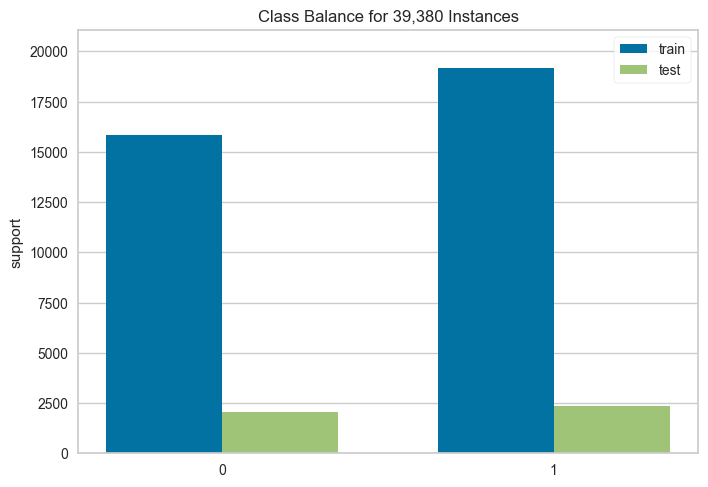

<AxesSubplot: title={'center': 'Class Balance for 39,380 Instances'}, ylabel='support'>

In [20]:
from yellowbrick.target import ClassBalance

# Instantiate the visualizer
visualizer = ClassBalance(labels=["0", "1"])

visualizer.fit(y_train, y_val)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Modelling

Baseline Model - DummyClassifier ✔

==========================

Feature Selection 
- LASSO (prefered)
- RFE

==========================

- Logistics Regression
- KNN
- Gaussian (Naive Bayees)

- Decision Tree
- Random Forest

- LightGBM
- XGBoost
- AdsBoost


## Baseline Model - DummyClassifier

In [22]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

Validation Result:

accuracy score: 0.5359



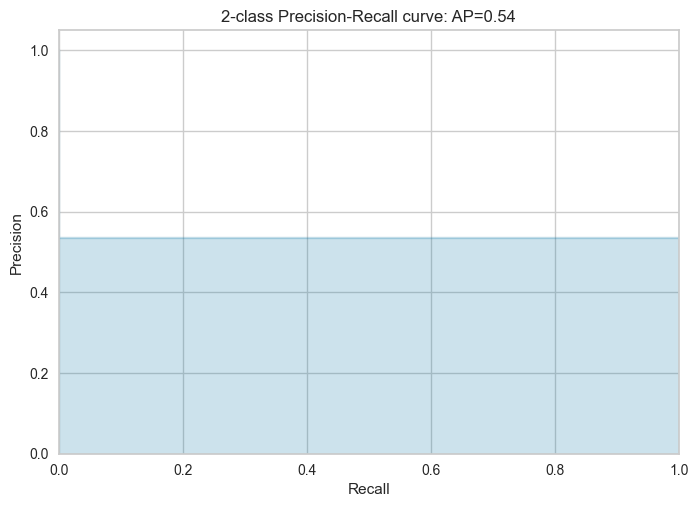

roc auc score: 0.5



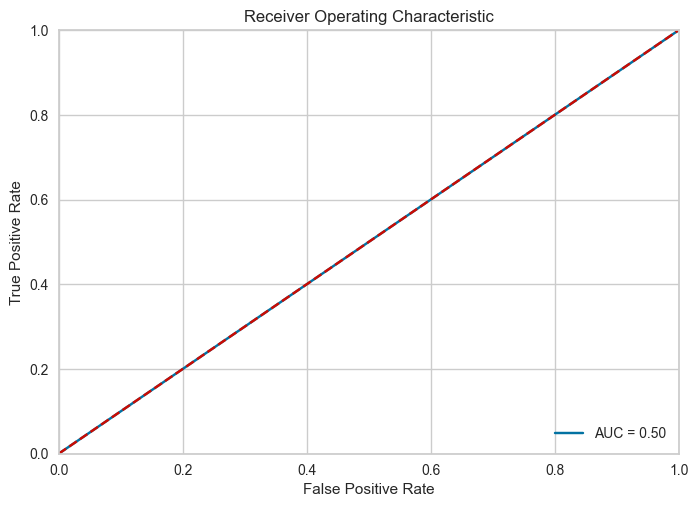

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2031
         1.0       0.54      1.00      0.70      2345

    accuracy                           0.54      4376
   macro avg       0.27      0.50      0.35      4376
weighted avg       0.29      0.54      0.37      4376


Confusion Matrix: 
 [[   0 2031]
 [   0 2345]]

End of validation Result



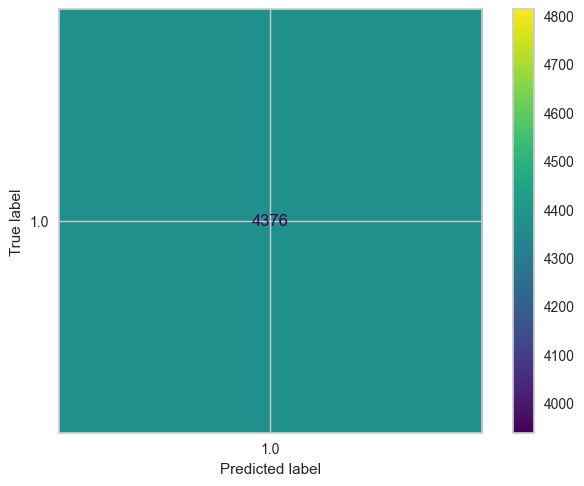

In [23]:
clf_score(dummy, X_train, y_train, X_val, y_val, train=False)

In [24]:
# Add result to model_comparison dataframe
model_name = 'DummyClassifier'
y_pred = dummy.predict(X_val)

add_result(model_name, y_val, y_pred)

                 precision  recall  f1-score support
DummyClassifier   0.535878     1.0  0.697813    2345


## Feature Selection

### 1. LASSO

In [25]:
lasso = Lasso(alpha=0.01)
model_lasso = lasso.fit(X_train, y_train)

In [26]:
model_lasso.coef_

array([ 0.00044513, -0.13973791,  0.01361016,  0.        , -0.00894538,
        0.        ,  0.00582552, -0.        ,  0.09717539,  0.03391091,
        0.0275149 ,  0.04385917,  0.03912013,  0.02210841,  0.03506695,
        0.01830838,  0.02908356, -0.00350892,  0.        ,  0.08976133,
        0.20718092])

In [27]:
pd.DataFrame(list(zip(X_train.columns,abs(model_lasso.coef_))), columns = ['predictor','coefficient']).sort_values(by='coefficient')

,predictor,coefficient
18,Gender_Male,0.000000
3,Inflight_wifi_service,0.000000
5,Ease_of_Online_booking,0.000000
7,Food_and_drink,0.000000
0,Age,0.000445
17,Departure_Delay_in_Minutes,0.003509
6,Gate_location,0.005826
4,Departure/Arrival_time_convenient,0.008945
2,Flight_Distance,0.013610
15,Inflight_service,0.018308


### 2. RFE

In [28]:
from sklearn.feature_selection import RFE

lr = LogisticRegression(max_iter=5000)
rfe = RFE(lr, n_features_to_select=3) 
model_rfe = rfe.fit(X_train,y_train)

In [29]:
model_rfe.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False,  True,  True])

In [30]:
pd.DataFrame(list(zip(X_train.columns,model_rfe.ranking_)), 
             columns = ['predictor','ranking']).sort_values(by='ranking')

,predictor,ranking
10,Inflight_entertainment,1
19,Customer_Type_Loyal Customer,1
20,Type_of_Travel_Business travel,1
8,Online_boarding,2
1,Class,3
13,Baggage_handling,4
14,Checkin_service,5
11,On-board_service,6
16,Cleanliness,7
9,Seat_comfort,8


Based on the above results, we can drop 'Gender_Male','Gate_location','Age', 'Food_and_drink'. 

In [31]:
X_train = X_train.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
X_val = X_val.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])

## Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

# define model
model = LogisticRegression()
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2', 'elasticnet']

# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
model_lg = search.fit(X_train, y_train)

Validation Result:

accuracy score: 0.9342



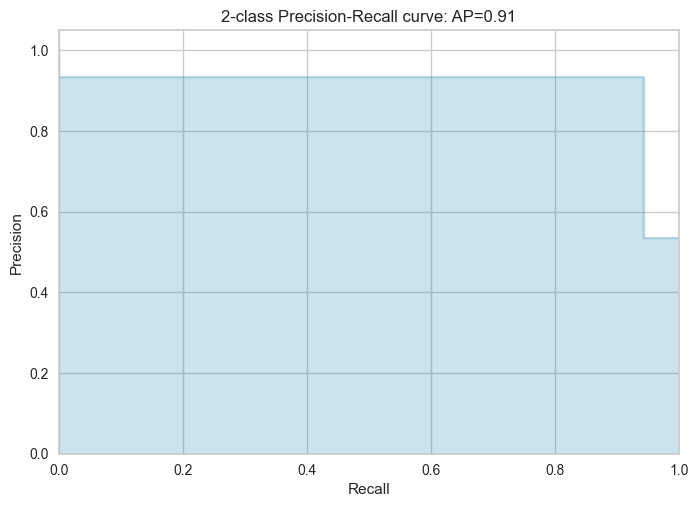

roc auc score: 0.9334173193958462



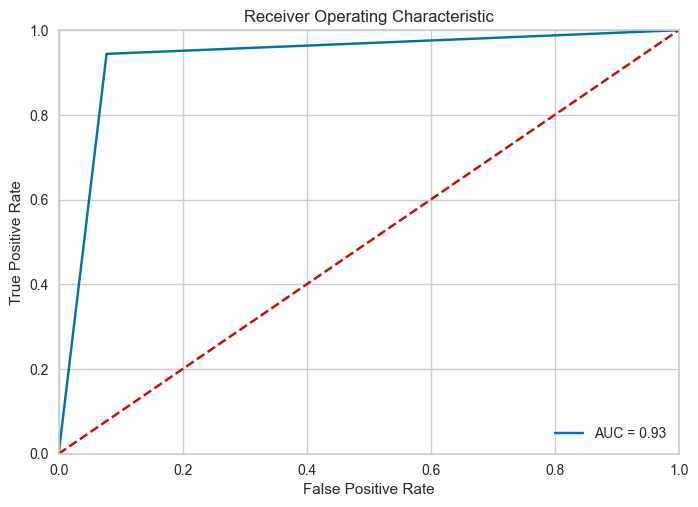

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.93      0.92      0.93      2031
         1.0       0.93      0.94      0.94      2345

    accuracy                           0.93      4376
   macro avg       0.93      0.93      0.93      4376
weighted avg       0.93      0.93      0.93      4376


Confusion Matrix: 
 [[1874  157]
 [ 131 2214]]

End of validation Result



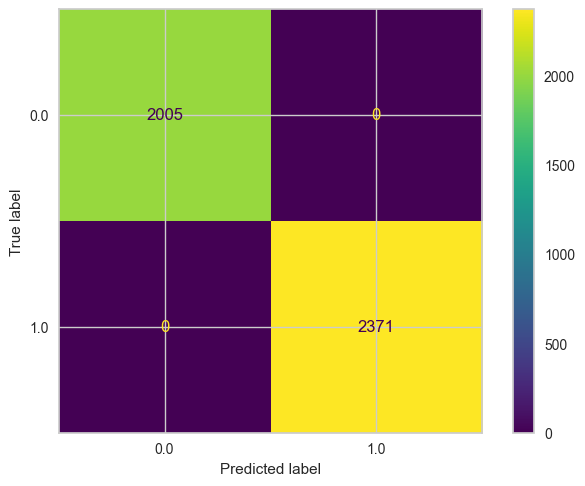

In [33]:

clf_score(model_lg, X_train, y_train, X_val, y_val, train=False)

In [35]:
# Add result to model_comparison dataframe
model_name = 'LogisticRegression'
y_pred = model_lg.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345


## K-Nearest Neighbor

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

n_neighbors = list(range(2,10))

#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors)
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)

Validation Result:

accuracy score: 0.9660



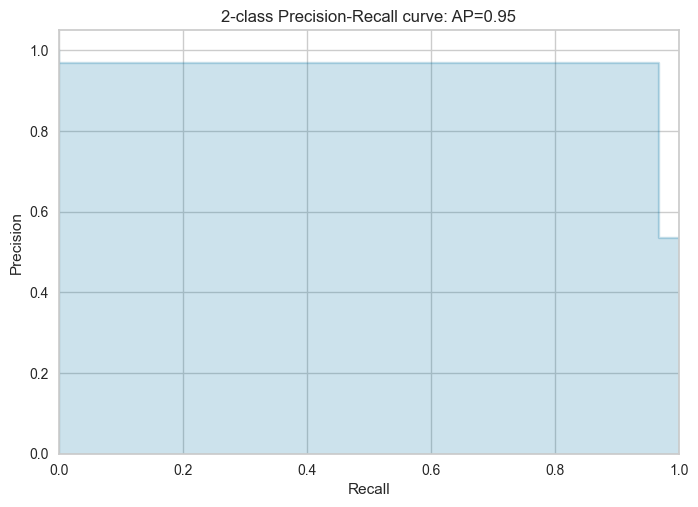

roc auc score: 0.9658238665293495



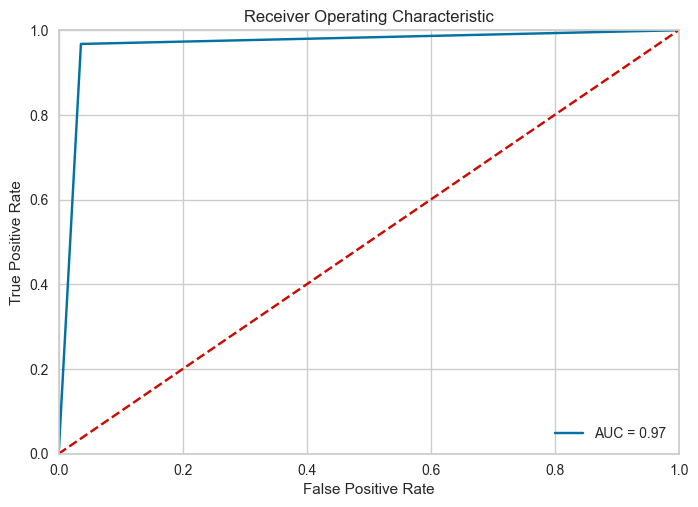

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      2031
         1.0       0.97      0.97      0.97      2345

    accuracy                           0.97      4376
   macro avg       0.97      0.97      0.97      4376
weighted avg       0.97      0.97      0.97      4376


Confusion Matrix: 
 [[1958   73]
 [  76 2269]]

End of validation Result



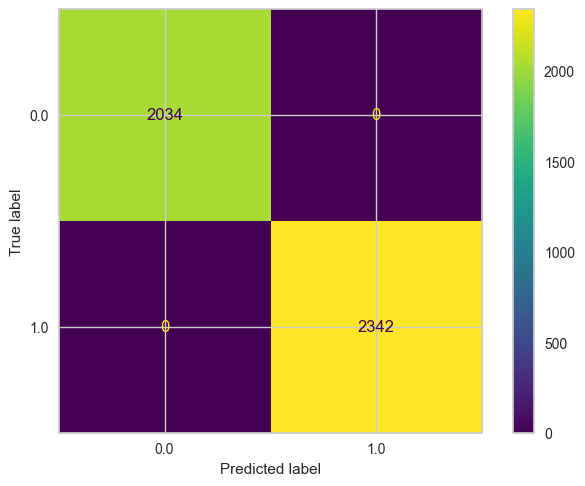

In [37]:
clf_score(best_model, X_train, y_train, X_val, y_val, train=False)

In [38]:
# Add result to model_comparison dataframe
model_name = 'KNN'
y_pred = best_model.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345


## Naive Bayesian

In [39]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
model = GaussianNB()
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=model, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

best_model = gs_NB.fit(X_train,y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


Validation Result:

accuracy score: 0.9180



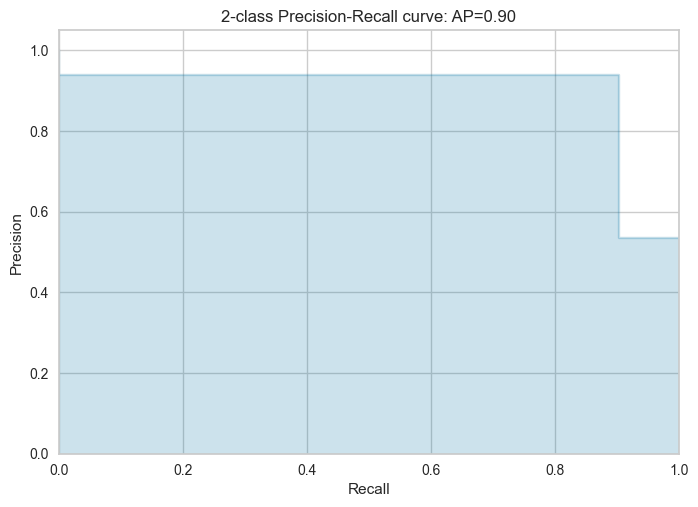

roc auc score: 0.9190039462951123



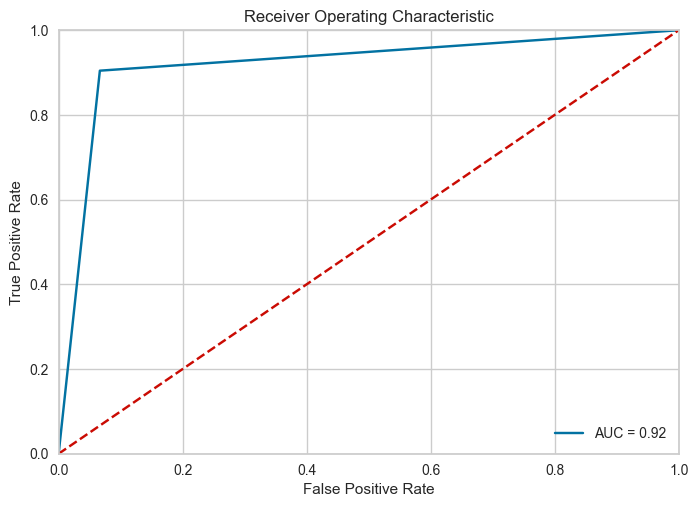

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      2031
         1.0       0.94      0.90      0.92      2345

    accuracy                           0.92      4376
   macro avg       0.92      0.92      0.92      4376
weighted avg       0.92      0.92      0.92      4376


Confusion Matrix: 
 [[1896  135]
 [ 224 2121]]

End of validation Result



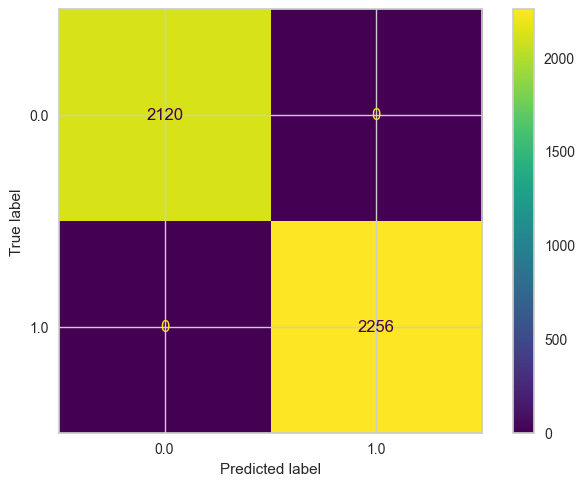

In [40]:
clf_score(best_model, X_train, y_train, X_val, y_val, train=False)

In [41]:
# Add result to model_comparison dataframe
model_name = 'Naive Bayesian'
y_pred = best_model.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345


## Decision Tree

In [42]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

Validation Result:

accuracy score: 0.9703



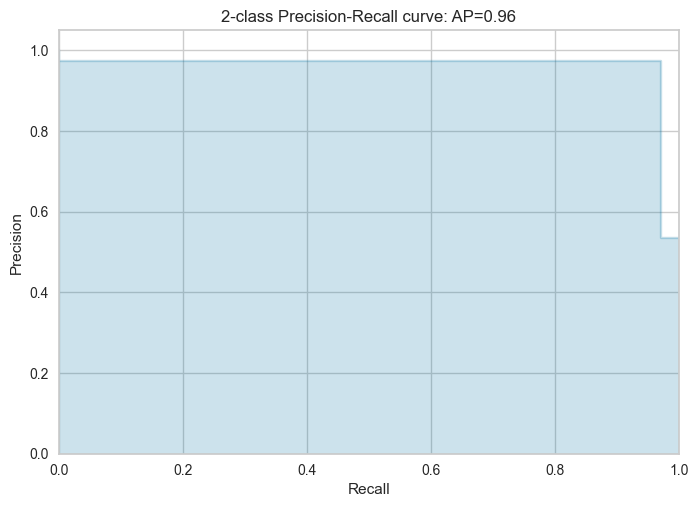

roc auc score: 0.9702376490621382



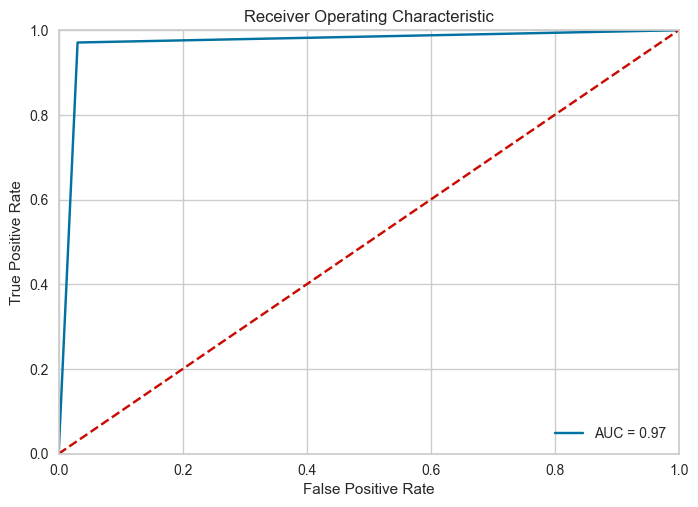

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      2031
         1.0       0.97      0.97      0.97      2345

    accuracy                           0.97      4376
   macro avg       0.97      0.97      0.97      4376
weighted avg       0.97      0.97      0.97      4376


Confusion Matrix: 
 [[1969   62]
 [  68 2277]]

End of validation Result



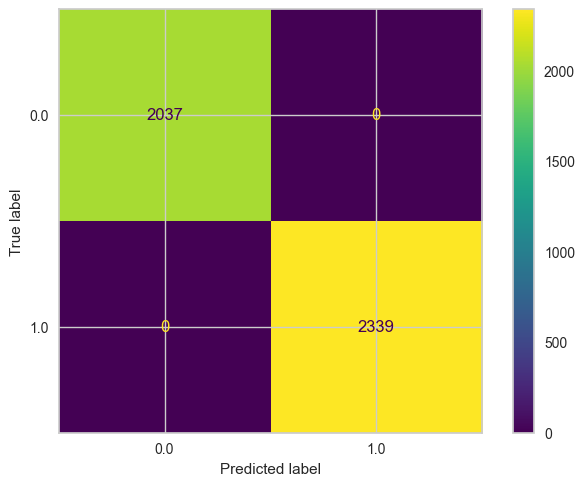

In [43]:
clf_score(grid_search, X_train, y_train, X_val, y_val, train=False)

In [44]:
# Add result to model_comparison dataframe
model_name = 'Decision Tree'
y_pred = grid_search.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345


## Random Forest

Validation Result:

accuracy score: 0.9760



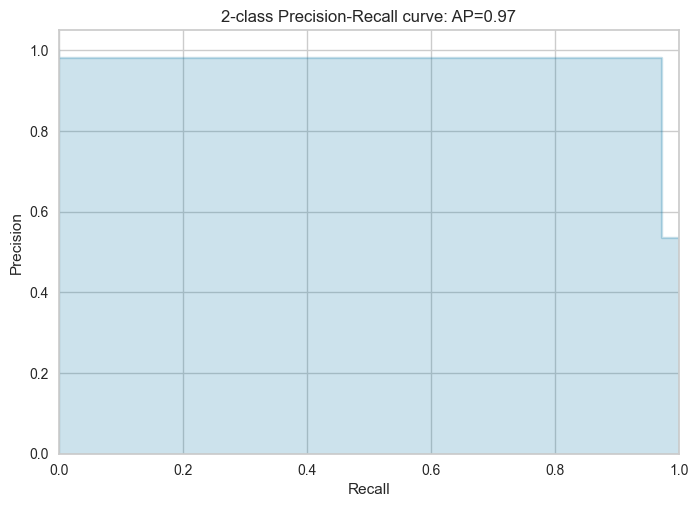

roc auc score: 0.9762274300579818



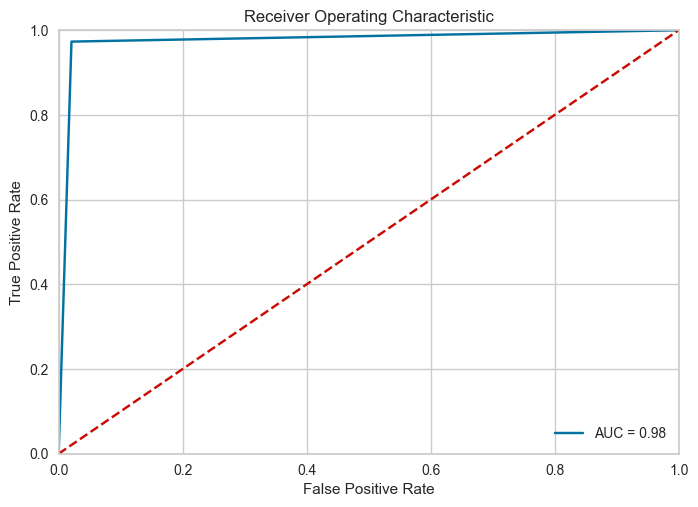

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1989   42]
 [  63 2282]]

End of validation Result



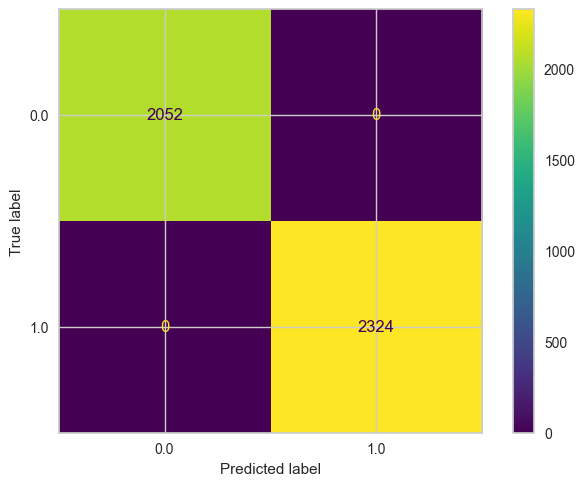

In [45]:
model_rf = RandomForestClassifier(n_estimators=2000, 
                                   max_features='sqrt',
                                   max_depth=35,
                                   bootstrap=False)
model_rf.fit(X_train,y_train)

clf_score(model_rf, X_train, y_train, X_val, y_val, train=False)

### Hyper-parameter tuning

In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 35, 60, 85, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=42)

In [47]:
print(rf_random.best_params_)

{'n_estimators': 1100, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': False}


Validation Result:

accuracy score: 0.9753



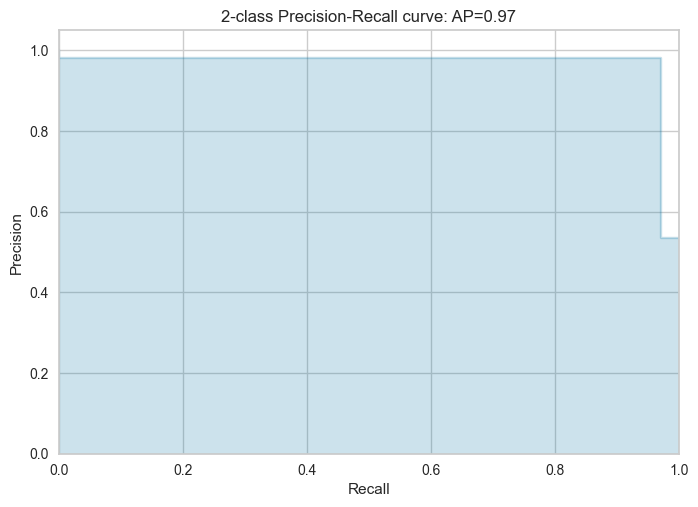

roc auc score: 0.9755548066798315



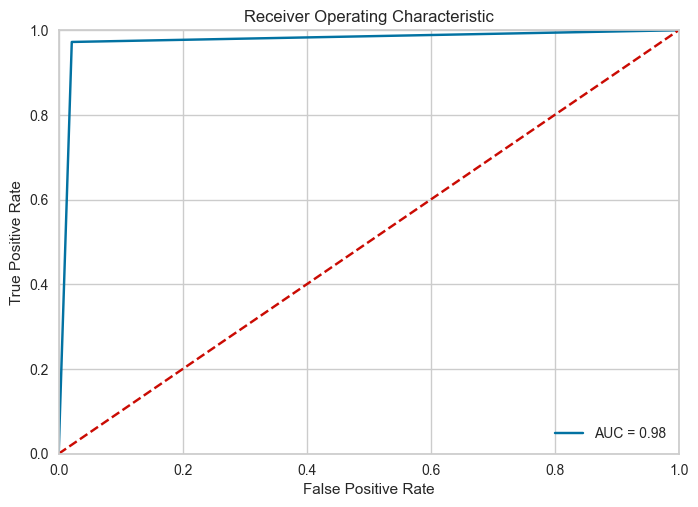

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2031
         1.0       0.98      0.97      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.97      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1988   43]
 [  65 2280]]

End of validation Result



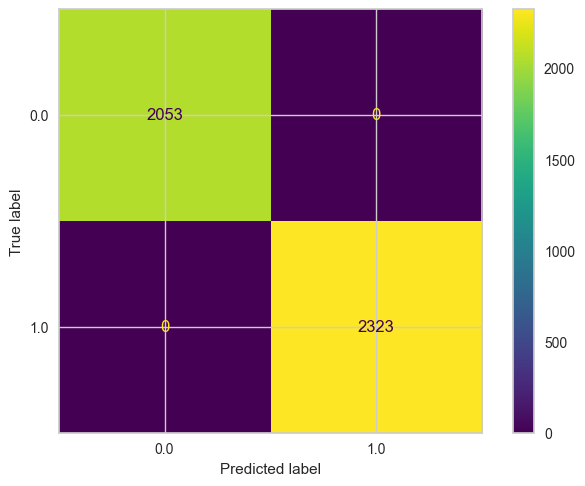

In [48]:
clf_score(rf_random, X_train, y_train, X_val, y_val, train=False)

In [49]:
# Add result to model_comparison dataframe
model_name = 'Random Forest'
y_pred = rf_random.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345
Random Forest        0.981489  0.972281  0.976864    2345


## LightGBM

In [50]:
lgbm_clf = LGBMClassifier(n_estimators=1000, 
                          n_jobs=1,
                          learning_rate=0.02,
                          num_leaves=50,
                          max_depth=7,
                          verbose=-1,
                          random_state=42)
model_lgbm= lgbm_clf.fit(X_train, y_train)

Validation Result:

accuracy score: 0.9774



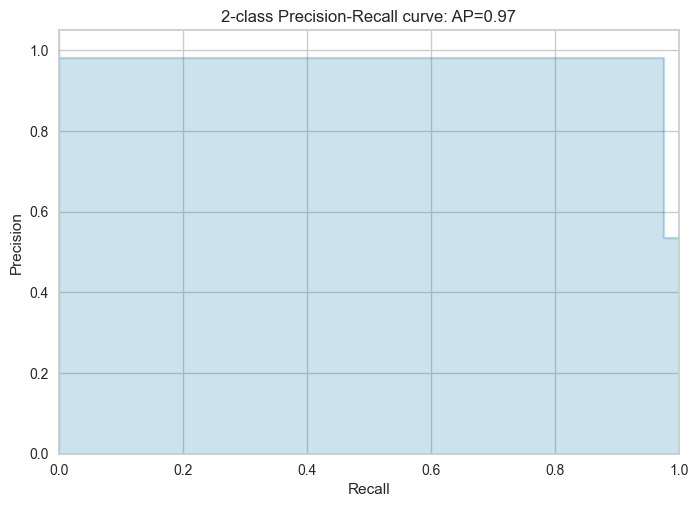

roc auc score: 0.9774408186961373



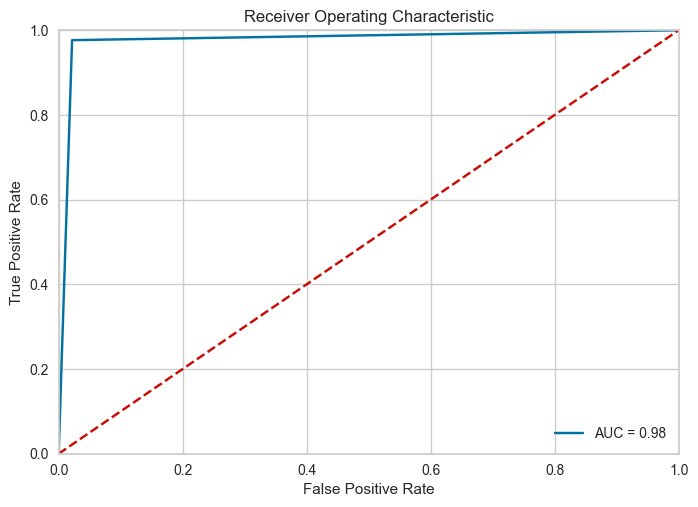

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98      2031
         1.0       0.98      0.98      0.98      2345

    accuracy                           0.98      4376
   macro avg       0.98      0.98      0.98      4376
weighted avg       0.98      0.98      0.98      4376


Confusion Matrix: 
 [[1987   44]
 [  55 2290]]

End of validation Result



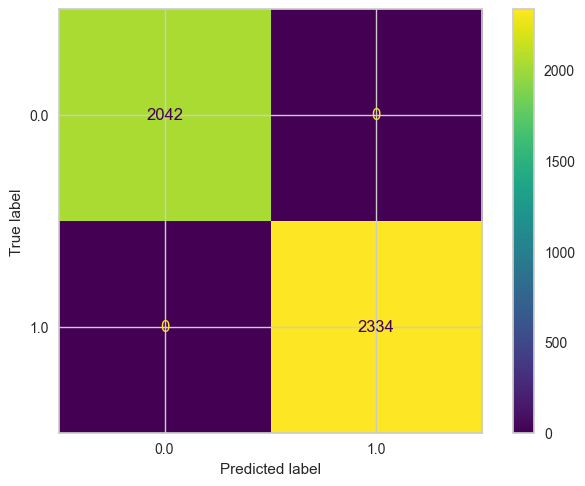

In [51]:
clf_score(model_lgbm, X_train, y_train, X_val, y_val, train=False)

In [52]:
# Add result to model_comparison dataframe
model_name = 'LightGBM'
y_pred = model_lgbm.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345
Random Forest        0.981489  0.972281  0.976864    2345
LightGBM             0.981148  0.976546  0.978842    2345


### Feature Importance

In [53]:
df_feature_importance = pd.DataFrame({'importance':model_lgbm.feature_importances_, 'feature': X_train.columns.values})
df_feature_importance.sort_values(by = 'importance', ascending=False)

,importance,feature
1,8876,Flight_Distance
14,3451,Departure_Delay_in_Minutes
2,3239,Inflight_wifi_service
0,2891,Class
10,2856,Baggage_handling
9,2798,Leg_room_service
11,2665,Checkin_service
3,2632,Departure/Arrival_time_convenient
7,2554,Inflight_entertainment
6,2327,Seat_comfort


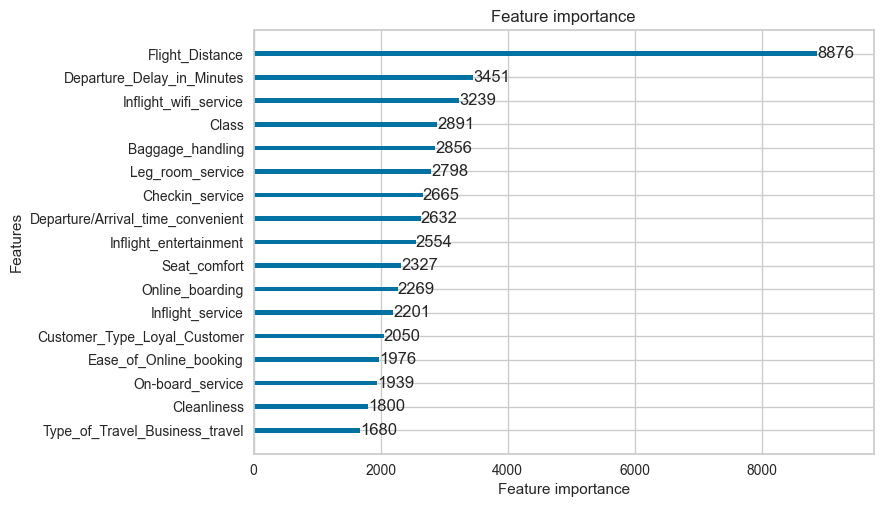

In [55]:
lgb.plot_importance(model_lgbm)
plt.rcParams['figure.figsize'] = [22, 6]
plt.show()

## SVM

Validation Result:

accuracy score: 0.9637



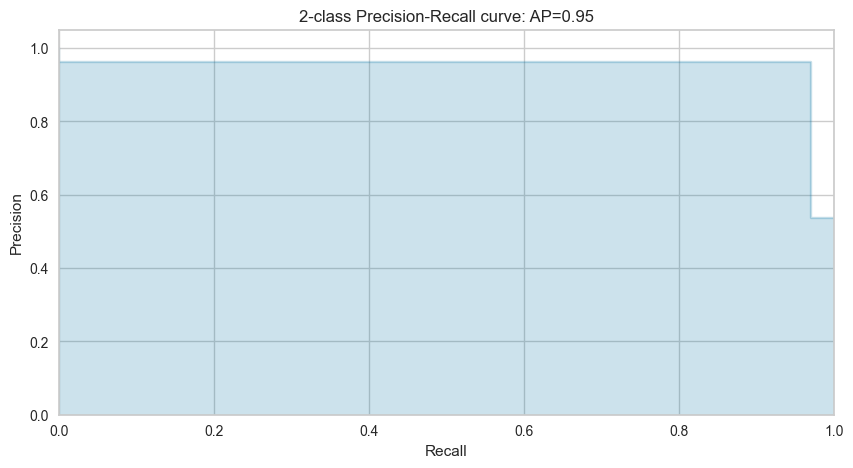

roc auc score: 0.9631312733651851



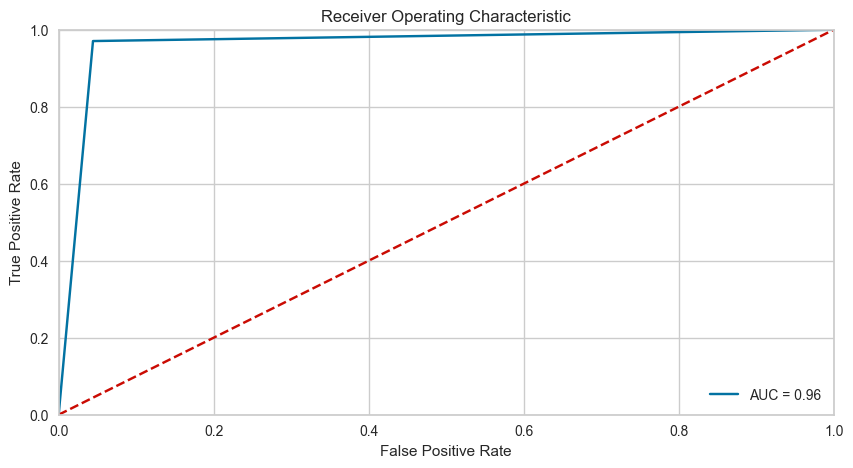

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      2031
         1.0       0.96      0.97      0.97      2345

    accuracy                           0.96      4376
   macro avg       0.96      0.96      0.96      4376
weighted avg       0.96      0.96      0.96      4376


Confusion Matrix: 
 [[1941   90]
 [  69 2276]]

End of validation Result



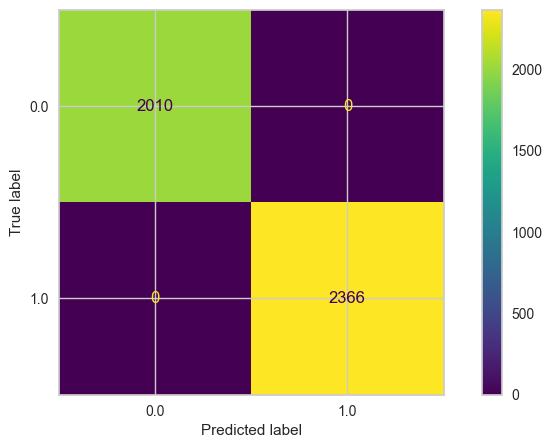

In [58]:
from sklearn import svm
plt.rcParams['figure.figsize'] = (10,5)

model_svm = svm.SVC().fit(X_train, y_train)

clf_score(model_svm, X_train, y_train, X_val, y_val, train=False)

In [59]:
# Add result to model_comparison dataframe
model_name = 'SVM'
y_pred = model_svm.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345
Random Forest        0.981489  0.972281  0.976864    2345
LightGBM             0.981148  0.976546  0.978842    2345
SVM                  0.961961  0.970576  0.966249    2345


## Adaboost

Adaboost (Adapative Boosting)

" The output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier. "

In [ ]:
% skip this cell

# Defining the classifier
ada = AdaBoostClassifier()

# Create a dict for the grid
ada_grid = dict()

# Specify a different number of decision stumps
ada_grid['n_estimators'] = [10, 50, 100, 500, 1000, 1500, 2000]

# Specify a different number of depth for the stump
#ada_grid['estimator'] = range(1,11)

# Specify a different number of learning rate
ada_grid['learning_rate'] = [0.1, 0.5, 1.0, 1.5, 2.0] #np.arange(0.1, 2.1, 0.1)

# Initialize the gridSearchCV
grid_search = GridSearchCV(estimator=ada, param_grid=ada_grid, 
                            n_jobs = -1, cv=10, scoring='accuracy', verbose=10)

# Train the model on grid search
grid_result = grid_search.fit(X_train, y_train)

# Finding the best results/hyperparameter
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
% skip this cell

best_params = grid_result.best_params_

best_n_est = best_params['n_estimators']
best_rate = best_params['learning_rate']

In [60]:
best_n_est = 100
best_rate = 0.1

adb_clf = AdaBoostClassifier(n_estimators=best_n_est, 
                              learning_rate=best_rate,
                              random_state=42)
model_adb = adb_clf.fit(X_train, y_train)

Validation Result:

accuracy score: 0.9452



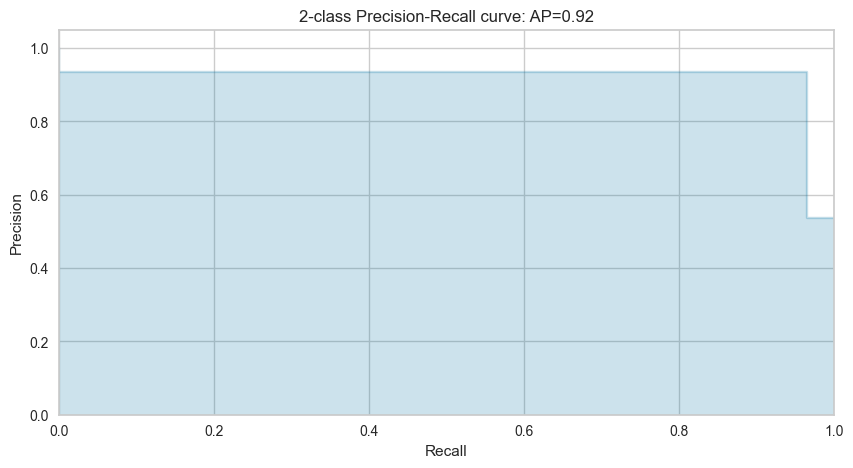

roc auc score: 0.9435859319145987



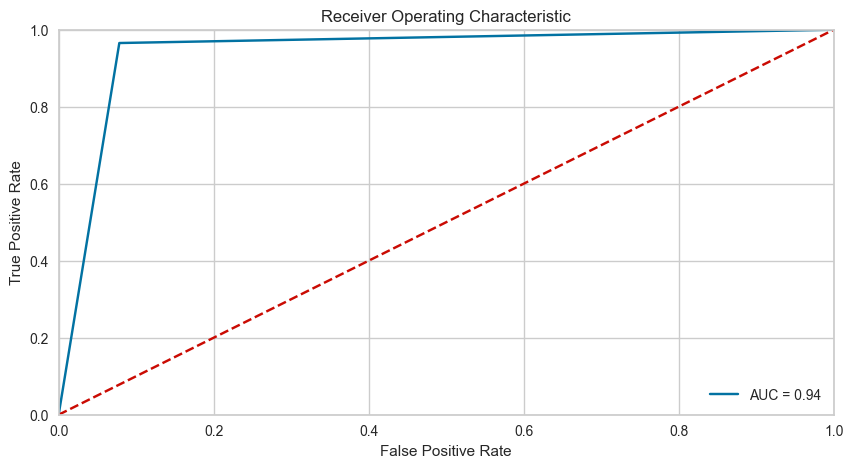

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.92      0.94      2031
         1.0       0.93      0.97      0.95      2345

    accuracy                           0.95      4376
   macro avg       0.95      0.94      0.94      4376
weighted avg       0.95      0.95      0.95      4376


Confusion Matrix: 
 [[1872  159]
 [  81 2264]]

End of validation Result



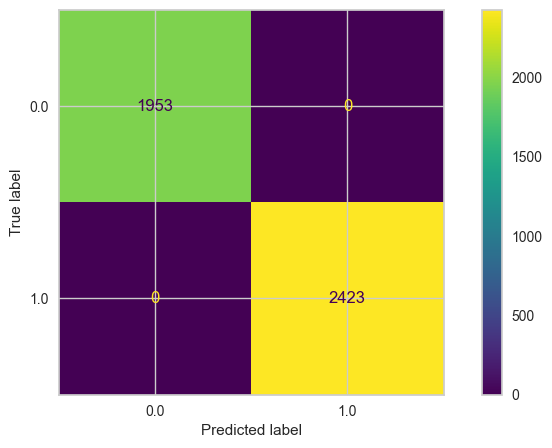

In [61]:
clf_score(model_adb, X_train, y_train, X_val, y_val, train=False)

In [62]:
# Add result to model_comparison dataframe
model_name = 'AdaBoost'
y_pred = model_adb.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score support
DummyClassifier      0.535878  1.000000  0.697813    2345
LogisticRegression   0.933783  0.944136  0.938931    2345
KNN                  0.968830  0.967591  0.968210    2345
Naive Bayesian       0.940160  0.904478  0.921973    2345
Decision Tree        0.973493  0.971002  0.972246    2345
Random Forest        0.981489  0.972281  0.976864    2345
LightGBM             0.981148  0.976546  0.978842    2345
SVM                  0.961961  0.970576  0.966249    2345
AdaBoost             0.934379  0.965458  0.949664    2345


In [63]:
model_comparison.to_csv('model_comparison.csv')

## Semi-supervised Learning

### Label Propagation KNN

In [23]:
X_1, X_2, X_3  = np.split(X, [int(.1*len(X)), int(.5*len(X))])
y_1, y_2, y_3  = np.split(y, [int(.1*len(y)), int(.5*len(y))])
y_1_2 = np.concatenate((y_1, y_2.apply(lambda x: -1)))
X_1_2 = np.concatenate((X_1, X_2))

In [20]:
def label_prop_test(kernel, params_list, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    if kernel == 'rbf':
        for g in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:,1]))
    if kernel == 'knn':
        for n in params_list:
            lp = LabelPropagation(kernel=kernel, n_neighbors=n, gamma=g, max_iter=100000, tol=0.0001)
            lp.fit(X_train, y_train)
            roc_scores.append(roc_auc_score(y_test, lp.predict_proba(X_test)[:,1]))
    plt.figure(figsize=(16,8));
    plt.plot(params_list, roc_scores)
    plt.title('Label Propagation ROC AUC with ' + kernel + ' kernel')
    plt.show()
    print('Best metrics value is at {}'.format(params_list[np.argmax(roc_scores)]))

<Figure size 2000x1000 with 0 Axes>

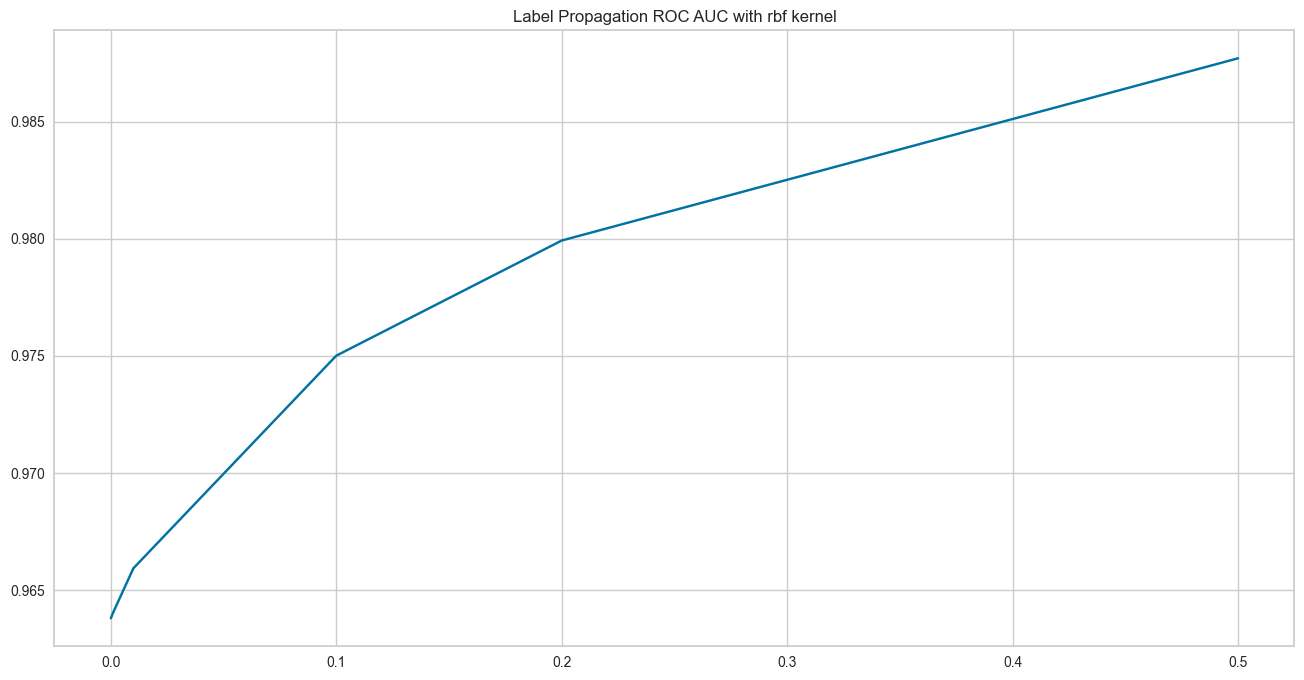

Best metrics value is at 0.5


In [22]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
gammas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 2e-1,5e-1]
label_prop_test('rbf', gammas, X_1_2, X_3, y_1_2, y_3)

In [28]:
lp_rbf = LabelPropagation(kernel='rbf', gamma= 0.5, max_iter=100000, tol=0.0001)
lp_rbf.fit(X_1_2, y_1_2)

model_name = 'LabelPropagation'
y_pred = lp_rbf.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score  support
DummyClassifier      0.535878  1.000000  0.697813     2345
LogisticRegression   0.933783  0.944136  0.938931     2345
KNN                  0.968830  0.967591  0.968210     2345
Naive Bayesian       0.940160  0.904478  0.921973     2345
Decision Tree        0.973493  0.971002  0.972246     2345
Random Forest        0.981489  0.972281  0.976864     2345
LightGBM             0.981148  0.976546  0.978842     2345
SVM                  0.961961  0.970576  0.966249     2345
AdaBoost             0.934379  0.965458  0.949664     2345
LabelPropagation     0.923297  0.965032  0.943703     2345


### Label Spreading

In [21]:
def labels_spread_test(kernel, hyperparam, alphas, X_train, X_test, y_train, y_test):
    plt.figure(figsize=(20,10))
    n, g = 0, 0
    roc_scores = []
    if kernel == 'rbf':
        g = hyperparam
    if kernel == 'knn':
        n = hyperparam
    for alpha in alphas:
        ls = LabelSpreading(kernel=kernel, n_neighbors=n, gamma=g, alpha=alpha, max_iter=1000, tol=0.001)
        ls.fit(X_train, y_train)
        roc_scores.append(roc_auc_score(y_test, ls.predict_proba(X_test)[:,1]))
    plt.figure(figsize=(16,8))
    plt.plot(alphas, roc_scores)
    plt.title('Label Spreading ROC AUC with ' + kernel + ' kernel')
    plt.show()
    print('Best metrics value is at {}'.format(alphas[np.argmax(roc_scores)]))

<Figure size 2000x1000 with 0 Axes>

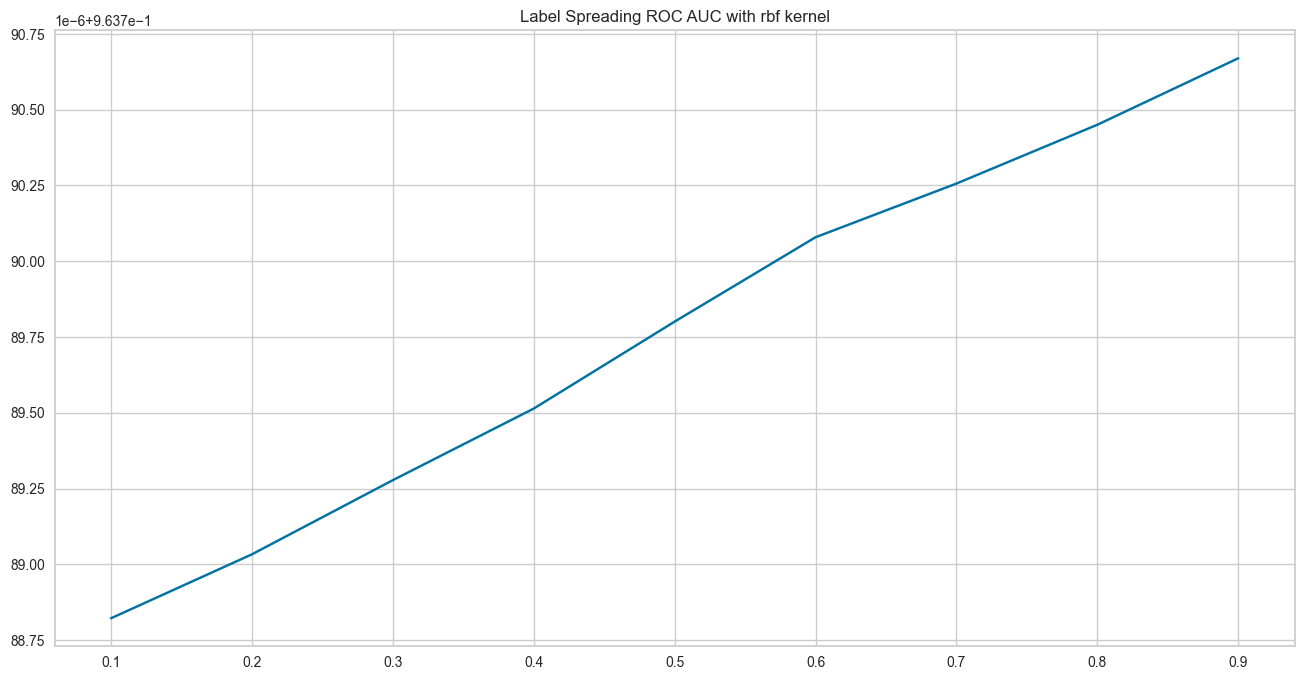

Best metrics value is at 0.9


In [24]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]  
labels_spread_test('rbf', 1e-5, alphas, X_1_2, X_3, y_1_2, y_3)

In [29]:
ls_rbf = LabelSpreading(kernel='rbf', gamma= 0.5, alpha=0.9, max_iter=1000, tol=0.001)
ls_rbf.fit(X_1_2, y_1_2)
model_name = 'Label Spreading'
y_pred = ls_rbf.predict(X_val)

add_result(model_name, y_val, y_pred)

                    precision    recall  f1-score  support
DummyClassifier      0.535878  1.000000  0.697813     2345
LogisticRegression   0.933783  0.944136  0.938931     2345
KNN                  0.968830  0.967591  0.968210     2345
Naive Bayesian       0.940160  0.904478  0.921973     2345
Decision Tree        0.973493  0.971002  0.972246     2345
Random Forest        0.981489  0.972281  0.976864     2345
LightGBM             0.981148  0.976546  0.978842     2345
SVM                  0.961961  0.970576  0.966249     2345
AdaBoost             0.934379  0.965458  0.949664     2345
LabelPropagation     0.923297  0.965032  0.943703     2345
Label Spreading      0.941752  0.944563  0.943155     2345


In [30]:
model_comparison.to_csv('model_comparison.csv')

# Evaluate model on test set

Given the results, LightGBM has the highest F1-Score. Now we test the model performance on the unseen test dataset.

In [64]:
print('before:', X_test.shape)
X_test = X_test.drop(columns=['Gender_Male', 'Gate_location', 'Food_and_drink', 'Age'])
print('after', X_test.shape)

before: (4376, 21)
after (4376, 17)


In [65]:
best_model = model_lgbm

#### Class Predictor Error

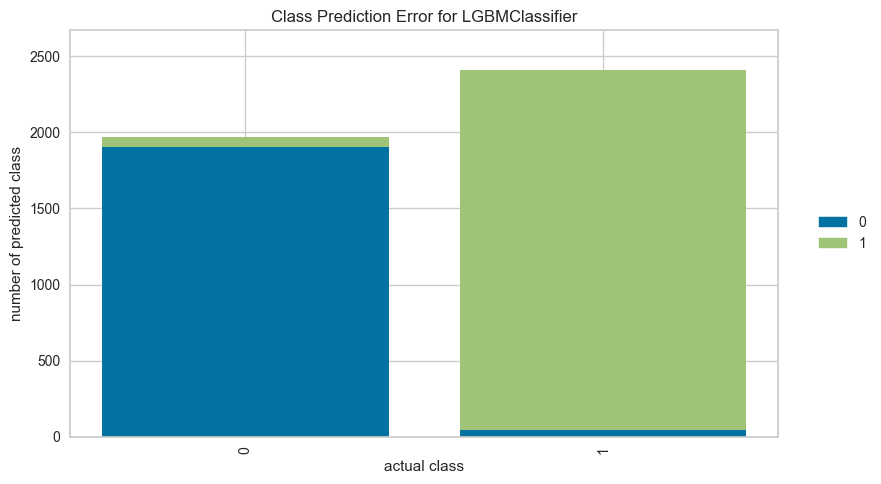

<AxesSubplot: title={'center': 'Class Prediction Error for LGBMClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [66]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

from yellowbrick.classifier import ClassPredictionError

classes = ["0", "1"]

visualizer = ClassPredictionError(
    best_model, classes=classes, is_fitted=True
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

#### Classification Report

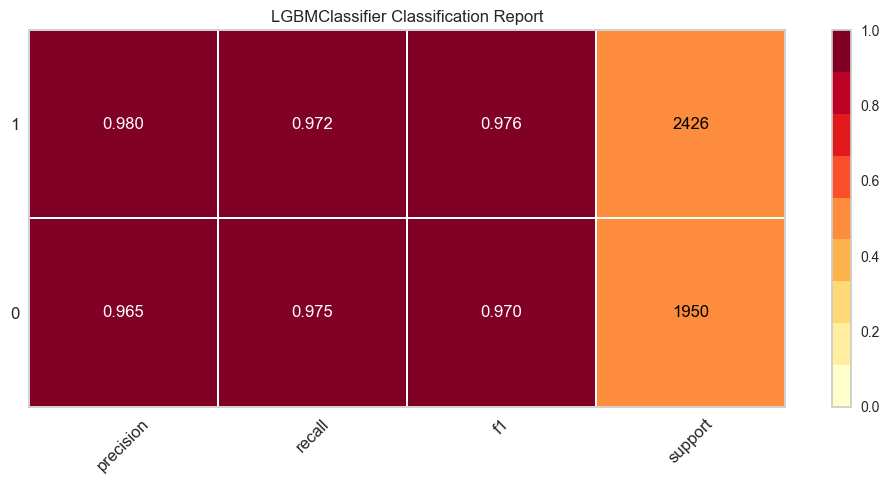

<AxesSubplot: title={'center': 'LGBMClassifier Classification Report'}>

In [67]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(
    best_model, classes=classes, support=True, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Confusion Matrix

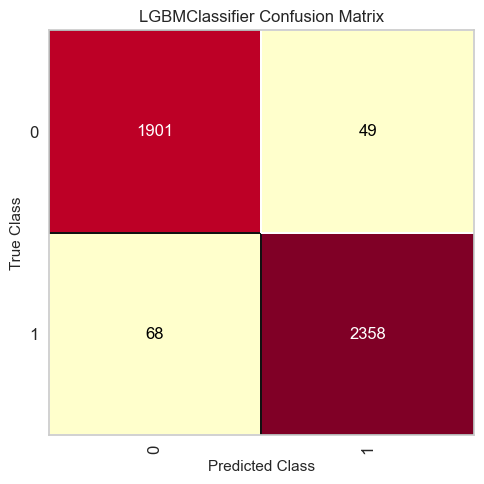

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [68]:
from yellowbrick.classifier import confusion_matrix, ConfusionMatrix
matplotlib.rcParams['figure.figsize'] = (5,5)

# The ConfusionMatrix visualizer taxes a model
cm = ConfusionMatrix(best_model, classes=[0,1], is_fitted=True)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

#### PR Curve

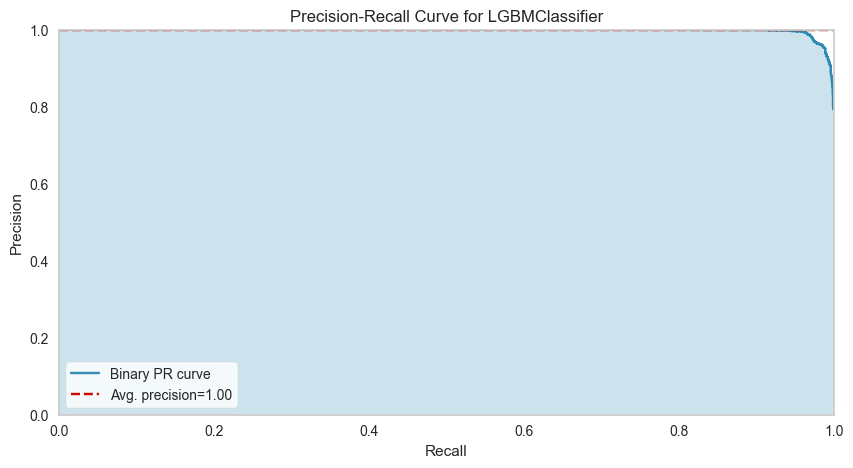

<AxesSubplot: title={'center': 'Precision-Recall Curve for LGBMClassifier'}, xlabel='Recall', ylabel='Precision'>

In [69]:
from yellowbrick.classifier import PrecisionRecallCurve
matplotlib.rcParams['figure.figsize'] = (10,5)

# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model, is_fitted=True)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

#### ROC-AUC

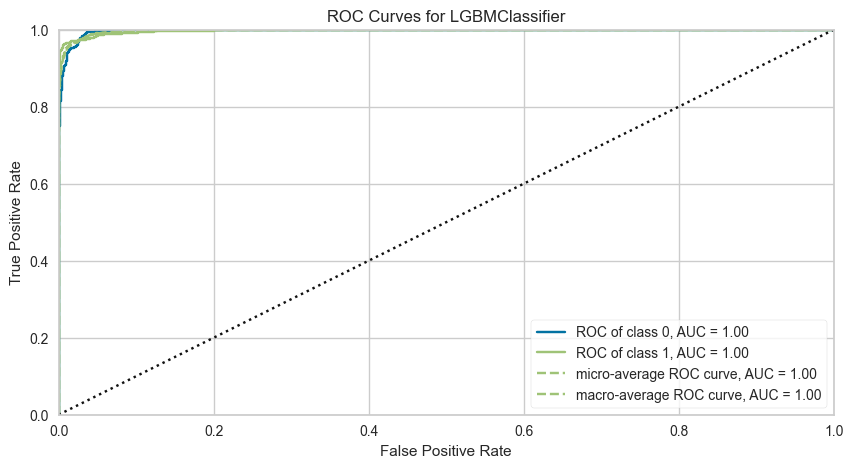

<AxesSubplot: title={'center': 'ROC Curves for LGBMClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [70]:
visualizer = ROCAUC(
    best_model, classes=classes, is_fitted=True
)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

#### Validation Curve

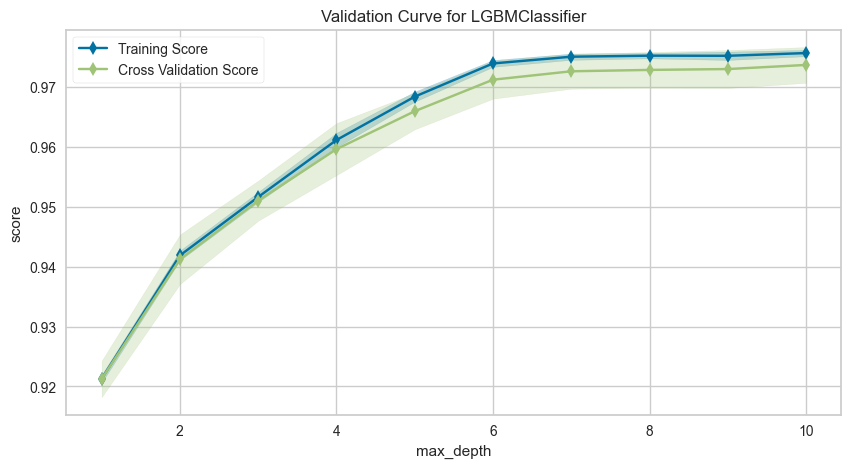

<AxesSubplot: title={'center': 'Validation Curve for LGBMClassifier'}, xlabel='max_depth', ylabel='score'>

In [71]:
from yellowbrick.model_selection import ValidationCurve

viz = ValidationCurve(
    LGBMClassifier(n_estimators=40, random_state=42), 
    param_name="max_depth",
    param_range=np.arange(1, 11), 
    cv=5, 
    scoring="f1_weighted",
    np_jobs=8
)

# Fit and show the visualizer
viz.fit(X_train, y_train)
viz.poof()